In [19]:
# Imports and GPU check
%matplotlib inline
import os
import random
import time

import librosa
import matplotlib.pyplot as plt
import numpy as np
import torchaudio
import torch
from torch import nn
from torchsummary import summary
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, Subset
from torchvision import models
from tqdm import tqdm
from itertools import product

# Fix HTTPS certificate error
import ssl
ssl_create_default_https_context = ssl._create_unverified_context

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Setting seed as 42 - COMMENT: This is from the Bootcamp! It is not used for now

In [20]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    # Python RNG
    random.seed(seed)
    
    # PyTorch RNGs
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # Numpy RNG
    np.random.seed(seed)
    
    # OS RNG
    os.environ['PYTHONHASHSEED'] = str(seed)

def worker_init_fn(worker_id):    
    """Ensure that the data loading process is deterministic."""
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    
set_seed(42)  

Hyperparameters - COMMENT: This is from the Bootcamp! It is not used for now

In [ ]:
# Hyperparameters
batch_size = 128
dataset_size = 5000  # Reduced dataset size for quicker training

epochs = 50
learning_rate = 0.001

ANNOTATIONS_FILE = ‘UrbanSound8K/metadata/UrbanSound8K.csv’
AUDIO_DIR = ‘UrbanSound8K/audio’
SAMPLE_RATE = 44100
NUM_SAMPLES = 22050

NOW IT FOLLOWS AN ADAPTATION OF https://www.analyticsvidhya.com/blog/2022/04/guide-to-audio-classification-using-deep-learning/ 

This is a test on using creating the MusicDataset as a class and importing sound, labels and metadata accordingly. It is made from Chatgpt

In [22]:
import os
import pandas as pd
import librosa
import torch
from torch.utils.data import Dataset, DataLoader

class MusicDataset(Dataset):
    #Initialising the 
    def __init__(self, data_dir, metadata_file, labels_dir, max_size_bytes=None):
        self.data_dir = data_dir
        self.metadata = pd.read_csv(metadata_file)
        self.labels_dir = labels_dir
        self.filenames = [filename for filename in os.listdir(data_dir) if filename.endswith('.wav')]
        if max_size_bytes is not None:
            total_size = 0
            new_filenames = []
            for filename in self.filenames:
                file_path = os.path.join(data_dir, filename)
                file_size = os.path.getsize(file_path)
                if total_size + file_size <= max_size_bytes:
                    new_filenames.append(filename)
                    total_size += file_size
                else:
                    break
            self.filenames = new_filenames

    def __len__(self):
        return len(self.filenames)
    
    
    def _cut_if_necessary(self, signal):
    # signal -> (1, num_sample)
        if signal.shape[1] > self.num_samples:
         signal = signal[:, :self.num_samples]
        return signal
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        file_path = os.path.join(self.data_dir, filename)
        audio, sr = librosa.load(file_path, sr=None)
        
        # Extract metadata for the current filename
        metadata_row = self.metadata[self.metadata['id'] == filename[:-4]]  # Removing '.wav' extension
        composer = metadata_row['composer'].values[0]
        composition = metadata_row['composition'].values[0]
        movement = metadata_row['movement'].values[0]
        ensemble = metadata_row['ensemble'].values[0]
        
        # Load labels for the current filename
        labels_file = os.path.join(self.labels_dir, filename[:-4] + '.csv')  # Removing '.wav' extension
        labels_data = pd.read_csv(labels_file)
        
        # You can process labels_data further as needed
        
        # You might want to perform additional preprocessing here
        
        return audio, composer, composition, movement, ensemble, labels_data
    
    def _right_pad_if_necessary(self, signal):
        len_signal = signal.shape[1]
        if len_signal < self.num_samples: # apply right pad
            num_missing_samples = self.num_samples - len_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_down_if_necessary(self, signal):
        # signal = (channels, num_samples) -> (2, 16000) -> (1, 16000)
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _get_audio_sample_path(self, item):
        fold = f"fold{self.annotations.iloc[item, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[item, 0])
        return path
# Example usage:
project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_data')
metadata_file = os.path.join(project_dir, 'Data', 'musicnet_metadata.csv')
labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_labels')
max_train_data_size = 1 * 1024 * 1024 * 1024  # 1GB in bytes
train_dataset = MusicDataset(train_data_dir, metadata_file, labels_dir, max_size_bytes=max_train_data_size)

# Create a DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Iterate over the DataLoader
"""for batch in train_loader:
    audio_batch, composer_batch, composition_batch, movement_batch, ensemble_batch, labels_batch = batch
    # Do something with the batch of audio data, metadata, and labels"""


'for batch in train_loader:\n    audio_batch, composer_batch, composition_batch, movement_batch, ensemble_batch, labels_batch = batch\n    # Do something with the batch of audio data, metadata, and labels'

In [30]:
print(train_dataset)

print(train_loader)

All instruments on a dictionary - Found in Kaggle (it is a quickfix) - https://www.kaggle.com/datasets/imsparsh/musicnet-dataset/discussion/303526

In [38]:
instruments_map = {
1: "Acoustic Grand Piano",
2: "Bright Acoustic Piano",
3: "Electric Grand Piano",
4: "Honky-tonk Piano",
5: "Electric Piano 1",
6: "Electric Piano 2",
7: "Harpsichord",
8: "Clavi",
9: "Celesta",
10: "Glockenspiel",
11: "Music Box",
12: "Vibraphone",
13: "Marimba",
14: "Xylophone",
15: "Tubular Bells",
16: "Dulcimer",
17: "Drawbar Organ",
18: "Percussive Organ",
19: "Rock Organ",
20: "Church Organ",
21: "Reed Organ",
22: "Accordion",
23: "Harmonica",
24: "Tango Accordion",
25: "Acoustic Guitar (nylon)",
26: "Acoustic Guitar (steel)",
27: "Electric Guitar (jazz)",
28: "Electric Guitar (clean)",
29: "Electric Guitar (muted)",
30: "Overdriven Guitar",
31: "Distortion Guitar",
32: "Guitar harmonics",
33: "Acoustic Bass",
34: "Electric Bass (finger)",
35: "Electric Bass (pick)",
36: "Fretless Bass",
37: "Slap Bass 1",
38: "Slap Bass 2",
39: "Synth Bass 1",
40: "Synth Bass 2",
41: "Violin",
42: "Viola",
43: "Cello",
44: "Contrabass",
45: "Tremolo Strings",
46: "Pizzicato Strings",
47: "Orchestral Harp",
48: "Timpani",
49: "String Ensemble 1",
50: "String Ensemble 2",
51: "SynthStrings 1",
52: "SynthStrings 2",
53: "Choir Aahs",
54: "Voice Oohs",
55: "Synth Voice",
56: "Orchestra Hit",
57: "Trumpet",
58: "Trombone",
59: "Tuba",
60: "Muted Trumpet",
61: "French Horn",
62: "Brass Section",
63: "SynthBrass 1",
64: "SynthBrass 2",
65: "Soprano Sax",
66: "Alto Sax",
67: "Tenor Sax",
68: "Baritone Sax",
69: "Oboe",
70: "English Horn",
71: "Bassoon",
72: "Clarinet",
73: "Piccolo",
74: "Flute",
75: "Recorder",
76: "Pan Flute",
77: "Blown Bottle",
78: "Shakuhachi",
79: "Whistle",
80: "Ocarina",
81: "Lead 1 (square)",
82: "Lead 2 (sawtooth)",
83: "Lead 3 (calliope)",
84: "Lead 4 (chiff)",
85: "Lead 5 (charang)",
86: "Lead 6 (voice)",
87: "Lead 7 (fifths)",
88: "Lead 8 (bass + lead)",
89: "Pad 1 (new age)",
90: "Pad 2 (warm)",
91: "Pad 3 (polysynth)",
92: "Pad 4 (choir)",
93: "Pad 5 (bowed)",
94: "Pad 6 (metallic)",
95: "Pad 7 (halo)",
96: "Pad 8 (sweep)",
97: "FX 1 (rain)",
98: "FX 2 (soundtrack)",
99: "FX 3 (crystal)",
100: "FX 4 (atmosphere)",
101: "FX 5 (brightness)",
102: "FX 6 (goblins)",
103: "FX 7 (echoes)",
104: "FX 8 (sci-fi)",
105: "Sitar",
106: "Banjo",
107: "Shamisen",
108: "Koto",
109: "Kalimba",
110: "Bag pipe",
111: "Fiddle",
112: "Shanai",
113: "Tinkle Bell",
114: "Agogo",
115: "Steel Drums",
116: "Woodblock",
117: "Taiko Drum",
118: "Melodic Tom",
119: "Synth Drum",
120: "Reverse Cymbal",
121: "Guitar Fret Noise",
122: "Breath Noise",
123: "Seashore",
124: "Bird Tweet",
125: "Telephone Ring",
126: "Helicopter",
127: "Applause",
128: "Gunshot"
}
instruments_list = []
for keys,values in instruments_map.items():
    print(keys)
    instruments_list.append(values)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128


This is a CNN network from the website - https://www.analyticsvidhya.com/blog/2022/04/guide-to-audio-classification-using-deep-learning/

In [33]:
from torch import nn
from torchsummary import summary


class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 CNN block / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=128*5*4, out_features=128)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

In [35]:
cnn = CNNNetwork()
summary(cnn.cpu(), (1, 64, 44))
# (1, 64, 44) is the shape of the signal which obtained in dataset.py by https://www.analyticsvidhya.com/blog/2022/04/guide-to-audio-classification-using-deep-learning/
#Our project is different

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 46]             160
              ReLU-2           [-1, 16, 66, 46]               0
         MaxPool2d-3           [-1, 16, 33, 23]               0
            Conv2d-4           [-1, 32, 35, 25]           4,640
              ReLU-5           [-1, 32, 35, 25]               0
         MaxPool2d-6           [-1, 32, 17, 12]               0
            Conv2d-7           [-1, 64, 19, 14]          18,496
              ReLU-8           [-1, 64, 19, 14]               0
         MaxPool2d-9             [-1, 64, 9, 7]               0
           Conv2d-10           [-1, 128, 11, 9]          73,856
             ReLU-11           [-1, 128, 11, 9]               0
        MaxPool2d-12            [-1, 128, 5, 4]               0
          Flatten-13                 [-1, 2560]               0
           Linear-14                   

In [ ]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [ ]:
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    for input , target in data_loader:
        input, target = input.to(device), target.to(device)
        # loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Loss: {loss.item()}")

In [ ]:
def train(model, data_loader, loss_fn, optimizer, epochs, device):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, data_loader, loss_fn, optimizer, device)
        print("-----------------------------------------------")
    print("Training completed!!")

In [ ]:
if torch.cuda.is_available():
device = "cuda"
else:
device = "cpu"
print(f"Using device {device}")

 # instantiate dataset
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
 sample_rate=SAMPLE_RATE,
n_fft=1024,
hop_length=512,
n_mels=64
)

 usd = UrbanSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram,
SAMPLE_RATE, NUM_SAMPLES, device)

 train_dataloader = create_data_loader(usd, BATCH_SIZE)

 cnn = CNNNetwork().to(device)
 print(cnn)

 loss_fn = nn.CrossEntropyLoss()
 optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

 # train
train(cnn, train_dataloader,loss_fn, optimizer, EPOCHS,device)

BELOW IS THE ORIGINAL CODE. Only exploration of data and data types of .wav is being featured.

Loading the whole dataset (20gbs, takes 4 and a half minutes and freezes pc)

In [6]:
"""import os
import librosa

def load_data_chunked(data_dir, chunk_size=100):
    data = []
    labels = []
    filenames = [filename for filename in os.listdir(data_dir) if filename.endswith('.wav')]
    num_files = len(filenames)
    num_chunks = num_files // chunk_size + 1

    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = min((i + 1) * chunk_size, num_files)
        chunk_data = []
        chunk_labels = []

        for filename in filenames[start_index:end_index]:
            file_path = os.path.join(data_dir, filename)
            audio, sr = librosa.load(file_path, sr=None)
            chunk_data.append(audio)
            chunk_labels.append(filename)  # Assuming labels are the filenames in this case
        
        data.append(chunk_data)
        labels.append(chunk_labels)
    
    return data, labels

# Assuming your project directory structure is like this:
# /PyCharm_project_folder
#     /Data
#         /musicnet
#             /train_data
#             /test_data
#             /train_labels
#             /test_labels

project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'Data', 'musicnet','musicnet', 'train_data')
test_data_dir = os.path.join(project_dir, 'Data', 'musicnet','musicnet', 'test_data')
train_labels_dir = os.path.join(project_dir, 'Data', 'musicnet','musicnet', 'train_labels')
test_labels_dir = os.path.join(project_dir, 'Data', 'musicnet','musicnet', 'test_labels')

# Load data in chunks
chunk_size = 10  # Adjust the chunk size as needed
train_data_chunks, train_labels_chunks = load_data_chunked(train_data_dir, chunk_size=chunk_size)
test_data_chunks, test_labels_chunks = load_data_chunked(test_data_dir, chunk_size=chunk_size)

# Do something with the loaded data chunks
for i, (chunk_data, chunk_labels) in enumerate(zip(train_data_chunks, train_labels_chunks)):
    print(f"Train data chunk {i+1}: {len(chunk_data)} files")
    print(f"Train labels chunk {i+1}: {len(chunk_labels)} labels")

for i, (chunk_data, chunk_labels) in enumerate(zip(test_data_chunks, test_labels_chunks)):
    print(f"Test data chunk {i+1}: {len(chunk_data)} files")
    print(f"Test labels chunk {i+1}: {len(chunk_labels)} labels")"""





'import os\nimport librosa\n\ndef load_data_chunked(data_dir, chunk_size=100):\n    data = []\n    labels = []\n    filenames = [filename for filename in os.listdir(data_dir) if filename.endswith(\'.wav\')]\n    num_files = len(filenames)\n    num_chunks = num_files // chunk_size + 1\n\n    for i in range(num_chunks):\n        start_index = i * chunk_size\n        end_index = min((i + 1) * chunk_size, num_files)\n        chunk_data = []\n        chunk_labels = []\n\n        for filename in filenames[start_index:end_index]:\n            file_path = os.path.join(data_dir, filename)\n            audio, sr = librosa.load(file_path, sr=None)\n            chunk_data.append(audio)\n            chunk_labels.append(filename)  # Assuming labels are the filenames in this case\n        \n        data.append(chunk_data)\n        labels.append(chunk_labels)\n    \n    return data, labels\n\n# Assuming your project directory structure is like this:\n# /PyCharm_project_folder\n#     /Data\n#         /

Loading only 1gb of train_data 

In [7]:
# 
def load_data(data_dir, max_size_bytes):
    waveform = []
    sample_rate = []
    filenames = []
    total_size = 0
    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            file_size = os.path.getsize(file_path)
            if total_size + file_size <= max_size_bytes:
                audio, sr = torchaudio.load(file_path)
                waveform.append(audio)
                sample_rate.append(sr)
                filenames.append(filename)  # Assuming labels are the filenames in this case
                total_size += file_size
            else:
                break
    return waveform, sample_rate, filenames

# Assuming your project directory structure is like this:
# /PyCharm_project_folder
#     /Data
#         /musicnet
#             /train_data
#             /test_data
#             /train_labels
#             /test_labels

project_dir = os.getcwd()
train_data_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_data')
test_data_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'test_data')
train_labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'train_labels')
test_labels_dir = os.path.join(project_dir, 'Data', 'musicnet', 'musicnet', 'test_labels')

# Load approximately 1GB of training data
max_train_data_size = 1 * 1024 * 1024 * 1024  # 1GB in bytes
waveform, sample_rate, filenames = load_data(train_data_dir, max_train_data_size)

# Do something with the loaded data
print("Wave Forms:", waveform)



Wave Forms: [tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[ 0.0000e+00, -3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.]])]


In [8]:
print(waveform[0])

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
print("Filenames:", filenames)

Filenames: ['1727.wav', '1728.wav', '1729.wav', '1730.wav', '1733.wav', '1734.wav', '1735.wav', '1739.wav', '1742.wav', '1749.wav', '1750.wav']


In [10]:
print("SampleRate:",sample_rate)

SampleRate: [44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100]


In [11]:
#Check metadata of the file to see it form
#metadata = torchaudio.info(waveform[0].raw)


AttributeError: 'Tensor' object has no attribute 'raw'

In [12]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

C:\Users\georg\PycharmProjects\deep_learning_music_project\venv\Lib\site-packages\matplotlib\axes\_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


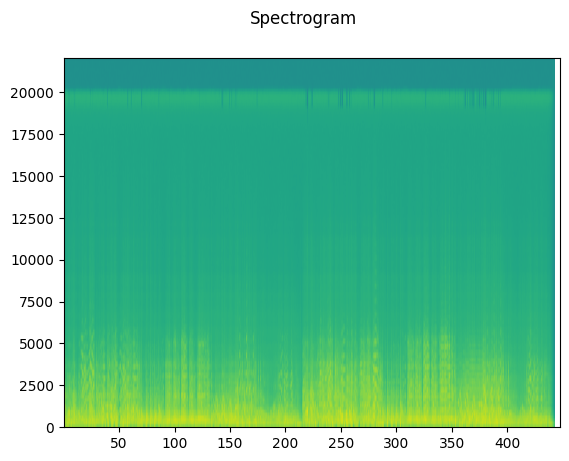

In [13]:
# It is running indefinitely
plot_specgram(waveform[0], sample_rate[0])